In [ ]:
from ultralytics import YOLO

# 학습한 weight 불러오기
model = YOLO("models/yolo11n.pt")

# ONNX 변환 (CPU용, GPU에서도 onnxruntime-gpu로 실행 가능)
model.export(format="onnx", opset=13, dynamic=True)

# 결과: runs/train/weights/ 아래에 model.onnx 생성됨


Ultralytics 8.3.200  Python-3.11.13 torch-2.5.1 CPU (Intel Xeon Gold 5218R 2.10GHz)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'models\yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

ONNX: starting export with onnx 1.19.0 opset 13...
ONNX: slimming with onnxslim 0.1.68...
ONNX: export success  2.8s, saved as 'models\yolo11n.onnx' (10.2 MB)

Export complete (3.1s)
Results saved to C:\Users\ty\Documents\sugyeo\sugyeo_detection\api\models
Predict:         yolo predict task=detect model=models\yolo11n.onnx imgsz=640  
Validate:        yolo val task=detect model=models\yolo11n.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'models\\yolo11n.onnx'

: 

In [5]:
from optimum.onnxruntime import ORTModelForSemanticSegmentation
from transformers import AutoImageProcessor

model_id = "nvidia/mit-b1"

# Image Processor (전처리)
processor = AutoImageProcessor.from_pretrained(model_id)

# ONNX 변환
onnx_model = ORTModelForSemanticSegmentation.from_pretrained(
    model_id,
    export=True,              # ONNX로 내보내기
    provider="CPUExecutionProvider",
)

# 저장
onnx_model.save_pretrained("./segformer-onnx")
processor.save_pretrained("./segformer-onnx")



Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['./segformer-onnx\\preprocessor_config.json']

In [5]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from pathlib import Path

id2label = {0: 'background', 1: 'river'}
label2id = {v: k for k, v in id2label.items()}

# 모델 로드
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b1",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
).to("cpu").eval()

ckpt = torch.load("./models/epoch=26-val_epoch_miou=0.9809.ckpt", map_location="cpu")
state = ckpt.get("state_dict", ckpt)
cleaned = { (k[6:] if k.startswith("model.") else k): v for k, v in state.items() }
model.load_state_dict(cleaned, strict=False)

processor = SegformerImageProcessor(do_resize=False)

# 더미 입력 (예: 3x512x512 이미지)
dummy = torch.randn(1, 3, 512, 512)

# 내보내기
torch.onnx.export(
    model,
    dummy,
    "./segformer-onnx/model.onnx",
    input_names=["pixel_values"],
    output_names=["logits"],
    opset_version=13,
    dynamic_axes={"pixel_values": {0: "batch", 2: "height", 3: "width"},
                  "logits": {0: "batch", 2: "height", 3: "width"}}
)

processor.save_pretrained("./segformer-onnx")


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ty\AppData\Local\Temp\ipykernel_19768\3598578833.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which

['./segformer-onnx\\preprocessor_config.json']

In [1]:
# Inference with YOLOv11n ONNX model
import onnxruntime as ort
import numpy as np
import cv2

session = ort.InferenceSession("./models/yolo11n.onnx", providers=["CPUExecutionProvider"])

# 입력 전처리 (예시)
image = cv2.imread("test.jpg")
orig_h, orig_w = image.shape[:2]

input_size = 640
img_resized = cv2.resize(image, (input_size, input_size))
img = img_resized.transpose(2, 0, 1) / 255.0
img = np.expand_dims(img, axis=0).astype(np.float32)

# 추론
outputs = session.run(None, {"images": img})
pred = outputs[0]  # shape: [1, num_boxes, 85]
pred = pred[0]     # batch 0

# ------------------- 4. 후처리 -------------------
conf_threshold = 0.3
boxes, scores, class_ids = [], [], []

for det in pred:
    conf = det[4]
    if conf < conf_threshold:
        continue
    # 클래스 확률 & class id
    class_prob = det[5:]
    class_id = np.argmax(class_prob)
    score = conf * class_prob[class_id]
    
    if score < conf_threshold:
        continue
    
    # 원래 이미지 기준 bbox
    cx, cy, w, h = det[0:4]
    x1 = int((cx - w / 2) * orig_w / input_size)
    y1 = int((cy - h / 2) * orig_h / input_size)
    x2 = int((cx + w / 2) * orig_w / input_size)
    y2 = int((cy + h / 2) * orig_h / input_size)
    
    boxes.append([x1, y1, x2, y2])
    scores.append(score)
    class_ids.append(class_id)

# ------------------- 5. 결과 시각화 -------------------
for box, score, class_id in zip(boxes, scores, class_ids):
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(
        image, f"ID:{class_id} {score:.2f}",
        (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1
    )

cv2.imshow("YOLOv11n Output", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


ONNX 입력 이름: pixel_values


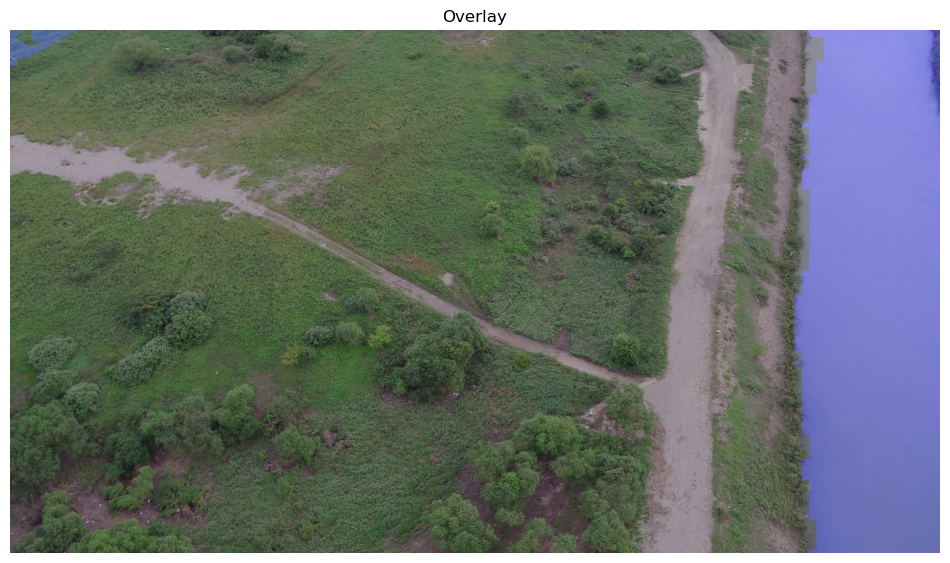

In [6]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# 세션 로드
session = ort.InferenceSession("./models/segformer-onnx/model.onnx", providers=["CPUExecutionProvider"])

input_name = session.get_inputs()[0].name
print("ONNX 입력 이름:", input_name)  # 보통 'pixel_values'

# 이미지 전처리 (SegFormer 기준)
image_path = "test.jpg"
image_pil = Image.open(image_path).convert("RGB")
orig_size = image_pil.size  # (width, height)

image = np.array(image_pil).astype(np.float32) / 255.0
image = cv2.resize(image, (512, 512))  # 모델 입력 크기
image = np.transpose(image, (2, 0, 1))  # HWC -> CHW
image = np.expand_dims(image, axis=0)   # batch 1

# 추론
outputs = session.run(None, {input_name: image})
logits = outputs[0][0]  # (num_labels, H, W)

mask = np.argmax(logits, axis=0)
mask = cv2.resize(mask, orig_size, interpolation=cv2.INTER_NEAREST)

# refine mask: operate on binary foreground only
kernel = np.ones((3,3), np.uint8)
fg = ((mask > 0).astype(np.uint8) * 255)
fg = cv2.morphologyEx(fg, cv2.MORPH_OPEN, kernel, iterations=1)
fg = cv2.morphologyEx(fg, cv2.MORPH_CLOSE, kernel, iterations=1)
mask = np.where(fg > 0, mask, 0).astype(np.uint8)

# ------------------- 5. 컬러맵 적용 -------------------
# 클래스별 색상 정의 (배경=검정, river=파랑)
colors = {
    0: (0, 0, 0),
    1: (0, 0, 255)
}

# RGB 마스크 생성
mask_color = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
for class_id, color in colors.items():
    mask_color[mask == class_id] = color

# ------------------- 6. 원본 이미지와 오버레이 -------------------
image_np = np.array(image_pil)
overlay = cv2.addWeighted(image_np, 0.7, mask_color, 0.3, 0)

# ------------------- 7. 시각화 -------------------
plt.figure(figsize=(12, 8))
# plt.subplot(1, 2, 1)
# plt.title("Original")
# plt.imshow(image_np)
# plt.axis("off")

# plt.subplot(1, 2, 2)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()


In [7]:
import json
import cv2
import numpy as np
from PIL import Image
import onnxruntime as ort

from app.utils.model_utils import get_model_path


# ---------------- YOLO ONNX 초기화 ----------------
yolo_weight_path = get_model_path("yolo11n.onnx")
yolo_sess = ort.InferenceSession(yolo_weight_path, providers=["CPUExecutionProvider"])
YOLO_INPUT_SIZE = 640

# ---------------- SegFormer ONNX 초기화 ----------------
seg_weight_path = get_model_path("segformer-onnx/model.onnx")
seg_sess = ort.InferenceSession(seg_weight_path, providers=["CPUExecutionProvider"])

seg_cfg_path = get_model_path("segformer-onnx/preprocessor_config.json")
with open(seg_cfg_path, "r") as f:
    cfg = json.load(f)

SEG_HEIGHT = cfg["size"]["height"]
SEG_WIDTH  = cfg["size"]["width"]
MEAN = np.array(cfg["image_mean"], dtype=np.float32)
STD  = np.array(cfg["image_std"], dtype=np.float32)
RESCALE = cfg.get("rescale_factor", 1/255.0)

# ---------------- Global NMS ----------------
def iou(a,b):
    x1=max(a[0],b[0]); y1=max(a[1],b[1])
    x2=min(a[2],b[2]); y2=min(a[3],b[3])
    inter=max(0,x2-x1)*max(0,y2-y1)
    ua=(a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
    return 0.0 if ua==0 else inter/ua

def nms_global(boxes, iou_thr):
    if not boxes: 
        return []
    boxes = sorted(boxes, key=lambda x: x["conf"], reverse=True)
    keep, used = [], [False] * len(boxes)
    for i in range(len(boxes)):
        if used[i]: 
            continue
        keep.append(boxes[i])
        for j in range(i+1, len(boxes)):
            if not used[j] and iou(boxes[i]["bbox"], boxes[j]["bbox"]) >= iou_thr:
                used[j] = True
    return keep

# ------------------- YOLO ONNX Tile 추론 -------------------
def _predict_tile_yolo(tile_img, conf_thr=0.25):
    h, w = tile_img.shape[:2]
    inp = cv2.resize(tile_img, (YOLO_INPUT_SIZE, YOLO_INPUT_SIZE))
    inp = inp.astype(np.float32) / 255.0
    inp = np.transpose(inp, (2,0,1))[np.newaxis, :, :, :]  # 1,3,640,640

    outputs = yolo_sess.run(None, {yolo_sess.get_inputs()[0].name: inp})
    arr = np.array(outputs[0])  # (1,*,*,*)
    pred = arr.reshape(arr.shape[0], arr.shape[2], -1)  # (1,84,8400) 형태 가정
    pred = pred[0].T  # (8400,84)

    bboxes = pred[:, 0:4]  # expect cx, cy, w, h (in pixels for 640 input)
    obj_conf = pred[:, 4]
    class_scores = pred[:, 5:]
    cls = np.argmax(class_scores, axis=1)
    conf = obj_conf * class_scores[np.arange(len(cls)), cls]

    boxes = []
    scale_x, scale_y = w / YOLO_INPUT_SIZE, h / YOLO_INPUT_SIZE
    for i in range(len(conf)):
        if conf[i] < conf_thr or cls[i] != 0:
            continue
        cx, cy, bw, bh = bboxes[i]
        x1 = (cx - bw/2) * scale_x
        y1 = (cy - bh/2) * scale_y
        x2 = (cx + bw/2) * scale_x
        y2 = (cy + bh/2) * scale_y

        x1 = int(max(0, min(w-1, x1)))
        y1 = int(max(0, min(h-1, y1)))
        x2 = int(max(0, min(w-1, x2)))
        y2 = int(max(0, min(h-1, y2)))

        if x2 <= x1 or y2 <= y1:
            continue

        boxes.append({"bbox": [x1, y1, x2, y2], "conf": float(conf[i]), "cls": int(cls[i])})
    return boxes

def run_yolo_onnx_sliding(image, tile_size=1280, overlap=0.5, conf_thr=0.25, iou_thr_global=0.6):
    H, W = image.shape[:2]
    stride = max(1, int(tile_size*(1-overlap)))
    all_boxes = []

    for y in range(0, H, stride):
        for x in range(0, W, stride):
            x2 = min(x+tile_size, W)
            y2 = min(y+tile_size, H)
            tile = image[y:y2, x:x2]
            if tile.size == 0:
                continue

            boxes = _predict_tile_yolo(tile, conf_thr=conf_thr)
            for b in boxes:
                bx = b["bbox"]
                gx1, gy1 = bx[0]+x, bx[1]+y
                gx2, gy2 = bx[2]+x, bx[3]+y
                all_boxes.append({"bbox":[gx1, gy1, gx2, gy2], "conf":b["conf"], "cls":b["cls"]})

    return nms_global(all_boxes, iou_thr_global)

# ------------------- Segformer ONNX -------------------
def run_segformer_onnx(image: np.ndarray):
    H, W = image.shape[:2]
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SEG_WIDTH, SEG_HEIGHT))
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2,0,1))[np.newaxis, :, :, :]  # 1,3,H,W

    outputs = seg_sess.run(None, {seg_sess.get_inputs()[0].name: img})
    logits = outputs[0]  # shape: 1,C,H,W
    mask = np.argmax(logits[0], axis=0).astype(np.uint8)

    # 원본 크기로 resize
    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
    return mask

# ------------------- Overlay -------------------
def overlay_yolo_and_seg(image: np.array, yolo_results: list, seg_mask: np.array):
    overlay = image.copy()
    mask_colored = np.zeros_like(image)
    mask_colored[seg_mask > 0] = [0, 255, 0]
    overlay = cv2.addWeighted(mask_colored, 0.6, overlay, 1.0, 0)
    for det in yolo_results:
        x1, y1, x2, y2 = det["bbox"]
        conf = det["conf"]
        cls = det["cls"]
        if cls == 0:
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0,0,255), 2)
            cv2.putText(overlay, f'{conf:.2f}', (x1, y1-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,0,255), 2, cv2.LINE_AA)
    return overlay


In [8]:
import cv2

image_path = "test.jpg"
image = cv2.imread(image_path)
# image = cv2.resize(image, (1920, 1080))
if image is None:
    print(f"이미지를 읽을 수 없습니다: {image_path}")

# YOLO 슬라이딩 윈도우 추론
yolo_boxes = run_yolo_onnx_sliding(image)

# Segformer ONNX 추론
seg_mask = run_segformer_onnx(image)

# YOLO + Segformer overlay
overlay_image = overlay_yolo_and_seg(image, yolo_boxes, seg_mask)

# 결과 시각화
cv2.imshow("Overlay Result", overlay_image)
print(f"YOLO 탐지 박스 개수: {len(yolo_boxes)}")
print(f"Segformer 마스크 shape: {seg_mask.shape}")

cv2.waitKey(0)
cv2.destroyAllWindows()

YOLO 탐지 박스 개수: 4
Segformer 마스크 shape: (2160, 3840)


In [1]:
import torch
from ultralytics import YOLO

def iou(a,b):
    x1=max(a[0],b[0]); y1=max(a[1],b[1])
    x2=min(a[2],b[2]); y2=min(a[3],b[3])
    inter=max(0,x2-x1)*max(0,y2-y1)
    ua=(a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
    return 0.0 if ua==0 else inter/ua

def nms_global(boxes, iou_thr):
    if not boxes: return []
    boxes = sorted(boxes, key=lambda x: x["conf"], reverse=True)
    keep, used = [], [False]*len(boxes)
    for i in range(len(boxes)):
        if used[i]: continue
        keep.append(boxes[i])
        for j in range(i+1,len(boxes)):
            if not used[j] and iou(boxes[i]["bbox"], boxes[j]["bbox"]) >= iou_thr:
                used[j]=True
    return keep

def _parse_device_str(dev_str: str) -> str:
    """args.device: '0'|'1'|'cpu'|'0,1' 등 -> ultralytics device 문자열"""
    dev_str = str(dev_str).strip().lower()
    if dev_str in ("cpu", "-1"):
        return "cpu"
    return dev_str

# ----------------------------- 추론: 슬라이딩 윈도우 -----------------------------
@torch.no_grad()
def _predict_tile_ultra(tile_img_bgr, model: YOLO, device: str,
                        conf_thr: float, iou_thr_tile: float, max_det: int,
                        scale: float):
    """
    Ultralytics YOLOv11n로 타일 1장 추론.
    - person(클래스 0)만 감지: classes=[0]
    - 작은 사람 대응: 필요 시 scale>1.0로 업샘플 후 감지, box는 원래 타일 좌표로 환산
    """
    th, tw = tile_img_bgr.shape[:2]

    if scale != 1.0:
        # 업샘플: 초소형 객체에 유리 (비용 증가)
        tile_up = cv2.resize(tile_img_bgr, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        up_h, up_w = tile_up.shape[:2]
        imgsz = max(up_h, up_w)  # 한쪽 최대를 imgsz로, letterbox 사용
        src = tile_up
        inv_scale = 1.0/scale
    else:
        imgsz = max(th, tw)
        src = tile_img_bgr
        inv_scale = 1.0

    results = model.predict(
        source=src,
        verbose=False,
        device=device,
        conf=conf_thr,
        iou=iou_thr_tile,
        classes=[0],        # person only
        max_det=max_det,
        imgsz=imgsz
    )
    out = []
    if not results:
        return out
    r = results[0]
    if r.boxes is None or len(r.boxes) == 0:
        return out

    xyxy = r.boxes.xyxy.detach().cpu().numpy()
    conf = r.boxes.conf.detach().cpu().numpy()
    cls  = r.boxes.cls.detach().cpu().numpy()

    # 업샘플 했다면 원래 타일 좌표로 복원
    for i in range(xyxy.shape[0]):
        x1, y1, x2, y2 = xyxy[i]
        if inv_scale != 1.0:
            x1 *= inv_scale; y1 *= inv_scale; x2 *= inv_scale; y2 *= inv_scale
        bx = [int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))]
        # 음수/초과 클램프
        bx[0] = max(0, min(bx[0], tw))
        bx[1] = max(0, min(bx[1], th))
        bx[2] = max(0, min(bx[2], tw))
        bx[3] = max(0, min(bx[3], th))
        if bx[2] > bx[0] and bx[3] > bx[1]:
            out.append({"bbox": bx, "conf": float(conf[i]), "cls": int(cls[i])})
    return out

@torch.no_grad()
def run_yolov11_sliding(image_path: str, model: YOLO, device: str,
                        tile=1280, overlap=0.5, conf_thr=0.25, iou_thr_tile=0.45,
                        iou_thr_global=0.6, max_det=3000, scale=1.0):
    """
    슬라이딩 윈도우(패딩 없음)로 전체 이미지 탐색 후 글로벌 NMS.
    - tile: 타일 한 변 길이 (정사각 형태로 슬라이드)
    - overlap: 타일 겹침 비율 (작을수록 빠름, 클수록 작은 객체/경계 보강)
    - scale: 타일 업샘플 배율(>1.0이면 초소형 객체 검출 강화, 비용↑)
    """
    im = cv2.imread(image_path)
    if im is None:
        raise FileNotFoundError(f"image load failed: {image_path}")
    H, W = im.shape[:2]

    stride = max(1, int(tile * (1 - overlap)))
    all_boxes = []

    for y in range(0, H, stride):
        for x in range(0, W, stride):
            x2 = min(x + tile, W)
            y2 = min(y + tile, H)
            tile_im = im[y:y2, x:x2]
            th, tw = tile_im.shape[:2]
            if th == 0 or tw == 0:
                continue

            rs = _predict_tile_ultra(tile_im, model, device,
                                     conf_thr=conf_thr, iou_thr_tile=iou_thr_tile,
                                     max_det=max_det, scale=scale)
            for r in rs:
                x1t, y1t, x2t, y2t = r["bbox"]
                # 타일 -> 전체 이미지 좌표로 변환
                gx1 = x1t + x; gy1 = y1t + y
                gx2 = x2t + x; gy2 = y2t + y
                # 클램프
                gx1 = max(0, min(gx1, W)); gy1 = max(0, min(gy1, H))
                gx2 = max(0, min(gx2, W)); gy2 = max(0, min(gy2, H))
                if gx2 > gx1 and gy2 > gy1:
                    all_boxes.append({"bbox": [gx1, gy1, gx2, gy2],
                                      "conf": r["conf"], "cls": r["cls"]})

    if not all_boxes:
        return [], im
    return nms_global(all_boxes, iou_thr_global), im

In [ ]:
from ultralytics import YOLO
import cv2

# YOLOv11 모델 불러오기 (pt 가중치 사용)
yolov11_model = YOLO("yolo11n.pt")

# 예측 실행
results = yolov11_model.predict(
    source="test.jpg",   # 입력 이미지
    device="cpu",        # CPU 사용
    conf=0.25,           # confidence threshold
    iou=0.45,            # IoU threshold
    classes=[0],         # 특정 클래스만 (예: 0번 클래스)
    max_det=3000         # 최대 detection 개수
)

for r in results:
    boxes = r.boxes
    if boxes is None or len(boxes) == 0:
        print("탐지된 박스 없음")
        continue

    for box in boxes:
        cls_id = int(box.cls)      # 클래스 ID
        conf = float(box.conf)     # confidence
        xyxy = box.xyxy.tolist()[0]  # [x1, y1, x2, y2]

        cls_name = r.names[cls_id]  # 클래스 이름 매핑
        print(f"Class: {cls_name} (id={cls_id}), conf={conf:.2f}, box={xyxy}")

    img = r.plot()

    cv2.imshow("YOLOv11 Result", img)
    cv2.waitKey(0)
cv2.destroyAllWindows()


image 1/1 c:\Users\ty\Documents\sugyeo-light\api\test.jpg: 384x640 (no detections), 93.5ms
Speed: 4.2ms preprocess, 93.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
탐지된 박스 없음


: 

In [ ]:
device = "cpu"  # "cuda:0" 가능
model = YOLO("yolo11n.pt")

# ------------------- 이미지 경로 -------------------
image_path = "test.jpg"

# ------------------- 슬라이딩 윈도우 추론 실행 -------------------
boxes, im = run_yolov11_sliding(
    image_path=image_path,
    model=model,
    device=device,
    tile=1280,         # 타일 크기
    overlap=0.5,       # 타일 겹침 비율
    conf_thr=0.25,     # confidence threshold
    iou_thr_tile=0.45, # 타일 내부 NMS IoU
    iou_thr_global=0.6,# 전체 NMS IoU
    max_det=3000,      # 최대 detection 수
    scale=1.0          # 업샘플 배율 (>1.0: 작은 객체 강화)
)

# ------------------- 결과 출력 -------------------
print(f"총 탐지 박스 개수: {len(boxes)}")
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box["bbox"]
    conf = box["conf"]
    cls = box["cls"]
    print(f"[{i}] cls={cls}, conf={conf:.3f}, bbox={x1,y1,x2,y2}")
    # 박스 그리기
    cv2.rectangle(im, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(im, f"{cls}:{conf:.2f}", (x1, y1-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

# ------------------- 시각화 -------------------
cv2.imshow("YOLOv11 Sliding Window Result", im)
cv2.waitKey(0)
cv2.destroyAllWindows()

WARNING imgsz=[880] must be multiple of max stride 32, updating to [896]
총 탐지 박스 개수: 0


: 

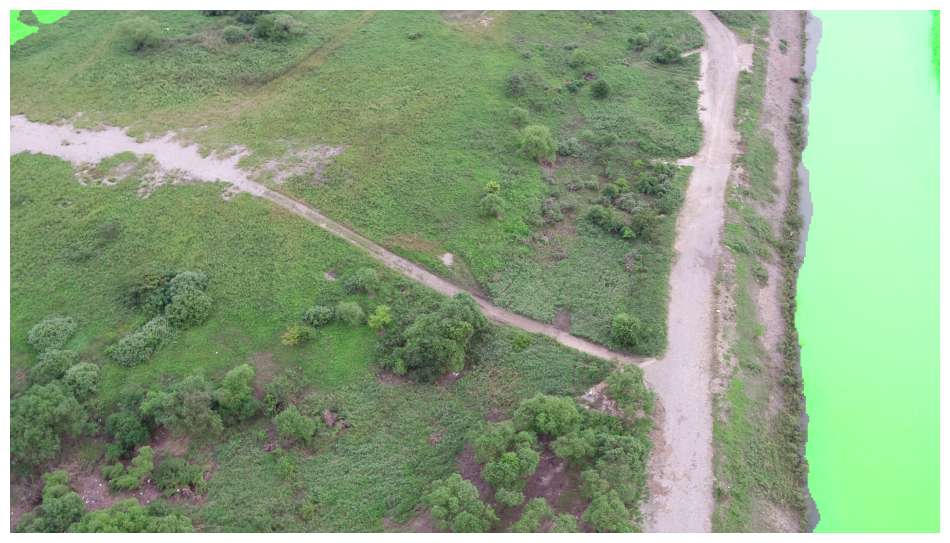

In [11]:
import json
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

from app.utils.model_utils import get_model_path


latest_alert = False

# ---------------- YOLO ONNX 초기화 ----------------
yolo_weight_path = get_model_path("yolo11n.onnx")
yolo_sess = ort.InferenceSession(yolo_weight_path, providers=["CPUExecutionProvider"])

# ---------------- SegFormer ONNX 초기화 ----------------
seg_weight_path = get_model_path("segformer-onnx/model.onnx")
seg_sess = ort.InferenceSession(seg_weight_path, providers=["CPUExecutionProvider"])

seg_cfg_path = get_model_path("segformer-onnx/preprocessor_config.json")
with open(seg_cfg_path, "r") as f:
    cfg = json.load(f)

SEG_HEIGHT = cfg["size"]["height"]
SEG_WIDTH  = cfg["size"]["width"]
MEAN = np.array(cfg["image_mean"], dtype=np.float32)
STD  = np.array(cfg["image_std"], dtype=np.float32)
RESCALE = cfg.get("rescale_factor", 1/255.0)

# ---------------- Global IOU + NMS ----------------
def iou(a, b):
    x1=max(a[0],b[0]); y1=max(a[1],b[1])
    x2=min(a[2],b[2]); y2=min(a[3],b[3])
    inter=max(0,x2-x1)*max(0,y2-y1)
    ua=(a[2]-a[0])*(a[3]-a[1]) + (b[2]-b[0])*(b[3]-b[1]) - inter
    return 0.0 if ua==0 else inter/ua

def nms_global(boxes, iou_thr):
    if not boxes: return []
    boxes = sorted(boxes, key=lambda x: x["conf"], reverse=True)
    keep, used = [], [False]*len(boxes)
    for i in range(len(boxes)):
        if used[i]: continue
        keep.append(boxes[i])
        for j in range(i+1,len(boxes)):
            if not used[j] and iou(boxes[i]["bbox"], boxes[j]["bbox"]) >= iou_thr:
                used[j]=True
    return keep

# ---------------- Tile Padding ----------------
def pad_tile(tile_img, stride=32):
    h, w = tile_img.shape[:2]
    pad_h = (stride - h % stride) % stride
    pad_w = (stride - w % stride) % stride
    if pad_h > 0 or pad_w > 0:
        tile_img = cv2.copyMakeBorder(tile_img, 0, pad_h, 0, pad_w,
                                      cv2.BORDER_CONSTANT, value=114)
    return tile_img, h, w  # 원래 타일 크기 반환

# ---------------- YOLO ONNX 타일 추론 ----------------
def _predict_tile_onnx(tile_img_bgr, session: ort.InferenceSession,
                       conf_thr=0.25, scale=1.0, stride=32):
    th, tw = tile_img_bgr.shape[:2]
    if scale != 1.0:
        tile_up = cv2.resize(tile_img_bgr, dsize=None, fx=scale, fy=scale,
                             interpolation=cv2.INTER_LINEAR)
        inv_scale = 1.0/scale
    else:
        tile_up = tile_img_bgr
        inv_scale = 1.0

    tile_pad, orig_h, orig_w = pad_tile(tile_up, stride)
    img = cv2.cvtColor(tile_pad, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    img = np.transpose(img, (2,0,1))[np.newaxis, ...]

    outputs = session.run(None, {session.get_inputs()[0].name: img})
    pred = outputs[0][0]  # (84, N)
    pred = pred.T         # (N, 84)

    out = []
    for row in pred:
        cx, cy, w, h = row[:4]
        class_confs = row[4:]
        cls = int(np.argmax(class_confs))
        conf = float(class_confs[cls])
        if conf < conf_thr or cls != 0:  # cls=0(person)만
            continue
        x1 = cx - w/2; y1 = cy - h/2
        x2 = cx + w/2; y2 = cy + h/2
        x1 *= inv_scale; x2 *= inv_scale
        y1 *= inv_scale; y2 *= inv_scale
        x1 = max(0, min(x1, orig_w)); x2 = max(0, min(x2, orig_w))
        y1 = max(0, min(y1, orig_h)); y2 = max(0, min(y2, orig_h))
        if x2 > x1 and y2 > y1:
            out.append({"bbox":[int(round(x1)), int(round(y1)),
                                int(round(x2)), int(round(y2))],
                        "conf": conf, "cls": cls})
    return out

# ---------------- Sliding Window ----------------
def run_yolov11_sliding_onnx(image: np.ndarray, session: ort.InferenceSession = yolo_sess,
                             tile=1280, overlap=0.5, conf_thr=0.25,
                             iou_thr_global=0.6, scale=1.0, stride=32):
    H, W = image.shape[:2]
    stride_tile = max(1, int(tile*(1-overlap)))
    all_boxes = []

    for i, y in enumerate(range(0, H, stride_tile)):
        for j, x in enumerate(range(0, W, stride_tile)):
            x2 = min(x+tile, W)
            y2 = min(y+tile, H)
            tile_im = image[y:y2, x:x2]
            th, tw = tile_im.shape[:2]
            if th==0 or tw==0: continue

            rs = _predict_tile_onnx(tile_im, session, conf_thr, scale, stride)
            for r in rs:
                x1t, y1t, x2t, y2t = r["bbox"]
                gx1 = x1t + x; gy1 = y1t + y
                gx2 = x2t + x; gy2 = y2t + y
                gx1 = max(0, min(gx1, W)); gy1 = max(0, min(gy1, H))
                gx2 = max(0, min(gx2, W)); gy2 = max(0, min(gy2, H))
                if gx2>gx1 and gy2>gy1:
                    all_boxes.append({"bbox":[gx1,gy1,gx2,gy2],
                                      "conf":r["conf"], "cls":r["cls"]})
    if not all_boxes:
        return []
    return nms_global(all_boxes, iou_thr_global)

# ------------------- Segformer -------------------
def run_segformer_onnx(image: np.ndarray):
    H, W = image.shape[:2]
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SEG_WIDTH, SEG_HEIGHT))
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2,0,1))[np.newaxis, :, :, :]

    outputs = seg_sess.run(None, {seg_sess.get_inputs()[0].name: img})
    logits = outputs[0]

    _, C, h_pred, w_pred = logits.shape
    
    upsampled = np.zeros((C, SEG_HEIGHT, SEG_WIDTH), dtype=np.float32)
    for c in range(C):
        upsampled[c] = cv2.resize(logits[0, c], (SEG_WIDTH, SEG_HEIGHT), interpolation=cv2.INTER_LINEAR)

    mask = np.argmax(upsampled, axis=0).astype(np.uint8)
    mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)
    return mask

# ---------------- Overlay -------------------
def overlay_yolo_and_seg(image: np.array, yolo_results: list, seg_mask: np.array):
    overlay = image.copy()
    mask_colored = np.zeros_like(image)
    mask_colored[seg_mask > 0] = [0, 255, 0]
    overlay = cv2.addWeighted(mask_colored, 0.6, overlay, 1.0, 0)

    for det in yolo_results:
        x1, y1, x2, y2 = det["bbox"]
        conf = det["conf"]
        cls = det["cls"]

        if cls == 0:
            x1c, y1c = max(0, x1), max(0, y1)
            x2c, y2c = min(seg_mask.shape[1], x2), min(seg_mask.shape[0], y2)
            overlap = np.any(seg_mask[y1c:y2c, x1c:x2c] > 0)

            color = (0, 0, 255) if overlap else (255, 0, 0)
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
            cv2.putText(overlay, f'{conf:.2f}', (x1, y1 - 6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2, cv2.LINE_AA)

    return overlay

def check_overlap(mask, bboxes) -> bool:
    for r in bboxes:
        x1, y1, x2, y2 = r["bbox"]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(mask.shape[1], x2), min(mask.shape[0], y2)
        if x2 <= x1 or y2 <= y1:
            continue
        if np.any(mask[y1:y2, x1:x2] > 0):
            return True
    return False


image_path = "test2.jpg"
frame = cv2.imread(image_path)

dets = run_yolov11_sliding_onnx(frame)
seg_mask = run_segformer_onnx(frame)
overlay_frame = overlay_yolo_and_seg(frame, dets, seg_mask)

latest_alert = check_overlap(seg_mask, dets)

# for i, box in enumerate(dets):
#     x1, y1, x2, y2 = box["bbox"]
#     conf = box["conf"]; cls = box["cls"]
#     print(f"[{i}] cls={cls}, conf={conf:.3f}, bbox={x1,y1,x2,y2}")
#     cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
#     cv2.putText(frame, f"{cls}:{conf:.2f}", (x1, y1-5),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(overlay_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
from PIL import Image
import cv2
import numpy as np

# ico 파일을 Pillow로 읽기
img = Image.open("favicon.ico").convert("RGBA")
print(img.size)  # 원본 크기 출력

# Pillow 이미지를 OpenCV 형식으로 변환
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGBA2BGRA)

# 크기 변경 (예: 256x256)
resized = cv2.resize(img_cv, (256, 256), interpolation=cv2.INTER_AREA)
# 다시 Pillow 형식으로 변환 후 저장
resized_pil = Image.fromarray(cv2.cvtColor(resized, cv2.COLOR_BGRA2RGBA))
resized_pil.save("icon_256.ico", format="ICO")


(48, 48)
